# Insight validation (Step 1E)

For each high-scoring candidate insight (relevance_score ≥ 4), recompute the KPI differences, chart the pattern, and capture caveats.

In [1]:

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

plt.style.use('seaborn-v0_8')
try:
    start_dir = Path(__file__).resolve().parent
except NameError:
    start_dir = Path.cwd().resolve()

# Locate data_clean.csv whether the notebook runs from the repo root or notebooks folder
DATA_PATH = None
for base in [start_dir, *start_dir.parents]:
    direct = base / 'data' / 'clean' / 'data_clean.csv'
    nested = base / 'Final Project' / 'Final Project Repo' / 'data' / 'clean' / 'data_clean.csv'
    if direct.exists():
        DATA_PATH = direct
        break
    if nested.exists():
        DATA_PATH = nested
        break

if DATA_PATH is None:
    raise FileNotFoundError(f'Could not find data_clean.csv relative to {start_dir}')

df = pd.read_csv(DATA_PATH)
df['date'] = pd.to_datetime(df['date'])

# Regime flags for 2018–2019 (pre), 2020–2022 (stress), 2023–2025 (recent)
def assign_regime(ts):
    year = ts.year
    if year <= 2019:
        return '2018-2019'
    elif year <= 2022:
        return '2020-2022'
    else:
        return '2023-2025'

df['regime'] = df['date'].apply(assign_regime)
regime_order = ['2018-2019', '2020-2022', '2023-2025']
df['regime'] = pd.Categorical(df['regime'], categories=regime_order, ordered=True)

regime_windows = df.groupby('regime')['date'].agg(['min', 'max', 'count']).rename(columns={'count': 'rows'})
regime_windows


C:\Users\betoq\AppData\Local\Temp\ipykernel_14856\1410528857.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  regime_windows = df.groupby('regime')['date'].agg(['min', 'max', 'count']).rename(columns={'count': 'rows'})


,min,max,rows
regime,,,
2018-2019,2018-01-01,2019-12-01,24
2020-2022,2020-01-01,2022-12-01,36
2023-2025,2023-01-01,2025-11-01,35


In [2]:

# Candidate insights table (manually curated for relevance)
candidate_insights = [
    {
        'id': 'CI1',
        'title': 'FFPI food level remains ~30 points higher post-2019',
        'kpi': 'ffpi_food',
        'relevance_score': 5,
        'pairs': [('2018-2019', '2020-2022'), ('2018-2019', '2023-2025')],
    },
    {
        'id': 'CI2',
        'title': 'Veg oils index surged during the 2020–2022 stress window',
        'kpi': 'ffpi_veg_oils',
        'relevance_score': 5,
        'pairs': [('2018-2019', '2020-2022'), ('2018-2019', '2023-2025')],
    },
    {
        'id': 'CI3',
        'title': 'Import price pressure (IPI food) stayed elevated through 2025',
        'kpi': 'ipi_food',
        'relevance_score': 4,
        'pairs': [('2018-2019', '2023-2025'), ('2020-2022', '2023-2025')],
    },
]

# Only keep those with relevance_score >= 4
pd.DataFrame(candidate_insights)


,id,title,kpi,relevance_score,pairs
0,CI1,FFPI food level remains ~30 points higher post...,ffpi_food,5,"[(2018-2019, 2020-2022), (2018-2019, 2023-2025)]"
1,CI2,Veg oils index surged during the 2020–2022 str...,ffpi_veg_oils,5,"[(2018-2019, 2020-2022), (2018-2019, 2023-2025)]"
2,CI3,Import price pressure (IPI food) stayed elevat...,ipi_food,4,"[(2018-2019, 2023-2025), (2020-2022, 2023-2025)]"


## CI1: FFPI food level remains ~30 points higher post-2019  

- KPI: **ffpi_food**  
- Relevance_score: **5**  
- Validation focus: Validate the step-change in the FAO food price index level after 2019.

In [3]:

ci1_kpi = 'ffpi_food'
ci1_summary = df.groupby('regime')[ci1_kpi].agg(mean='mean', median='median', N='count').reset_index()
ci1_summary['diff_vs_2018_2019'] = ci1_summary['mean'] - ci1_summary.loc[ci1_summary['regime'] == '2018-2019', 'mean'].iloc[0]
ci1_summary['ratio_vs_2018_2019'] = ci1_summary['mean'] / ci1_summary.loc[ci1_summary['regime'] == '2018-2019', 'mean'].iloc[0]
ci1_summary


C:\Users\betoq\AppData\Local\Temp\ipykernel_14856\1350111219.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ci1_summary = df.groupby('regime')[ci1_kpi].agg(mean='mean', median='median', N='count').reset_index()


,regime,mean,median,N,diff_vs_2018_2019,ratio_vs_2018_2019
0,2018-2019,95.333333,95.00,24,0.000000,1.000000
1,2020-2022,122.772222,126.70,36,27.438889,1.287821
2,2023-2025,124.541176,124.65,34,29.207843,1.306376


C:\Users\betoq\AppData\Local\Temp\ipykernel_14856\4025313024.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for reg, group in df.groupby('regime'):


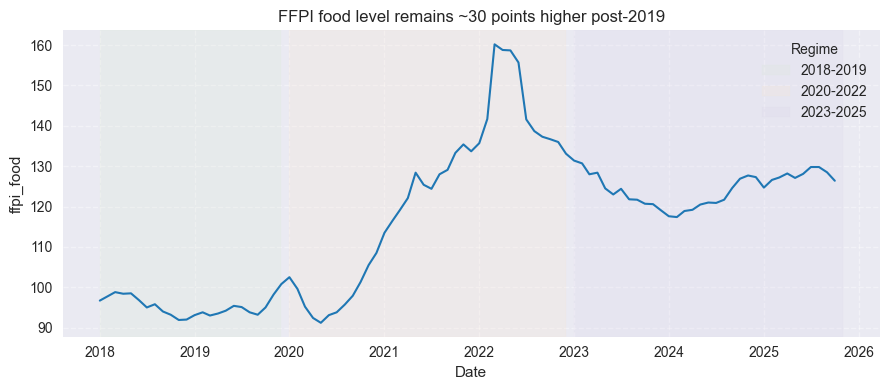

In [4]:

fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(df['date'], df['ffpi_food'], color='#1f77b4', linewidth=1.5)
ax.set_title('FFPI food level remains ~30 points higher post-2019')
ax.set_ylabel('ffpi_food')
ax.set_xlabel('Date')

# Shade regimes for context
regime_colors = {'2018-2019': '#d9ead3', '2020-2022': '#fce5cd', '2023-2025': '#d9d2e9'}
for reg, group in df.groupby('regime'):
    ax.axvspan(group['date'].min(), group['date'].max(), color=regime_colors.get(reg, '#f0f0f0'), alpha=0.2, label=reg)

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), title='Regime')
ax.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()


Caveats and context:
- Sample sizes by regime: 2018-2019 n=24, 2020-2022 n=36, 2023-2025 n=34.
- Date coverage: 2018-2019: 2018-01-01 to 2019-12-01, 2020-2022: 2020-01-01 to 2022-12-01, 2023-2025: 2023-01-01 to 2025-11-01.
- Key differences: 2020-2022 vs 2018-2019: Δ = 27.44, ratio = 1.29; 2023-2025 vs 2018-2019: Δ = 29.21, ratio = 1.31.
- Data caveats: No missing values flagged for this KPI; monthly cadence is intact.

## CI2: Veg oils index surged during the 2020–2022 stress window  

- KPI: **ffpi_veg_oils**  
- Relevance_score: **5**  
- Validation focus: Check the magnitude of the veg-oils spike relative to the pre-COVID baseline.

In [5]:

ci2_kpi = 'ffpi_veg_oils'
ci2_summary = df.groupby('regime')[ci2_kpi].agg(mean='mean', median='median', N='count').reset_index()
ci2_summary['diff_vs_2018_2019'] = ci2_summary['mean'] - ci2_summary.loc[ci2_summary['regime'] == '2018-2019', 'mean'].iloc[0]
ci2_summary['ratio_vs_2018_2019'] = ci2_summary['mean'] / ci2_summary.loc[ci2_summary['regime'] == '2018-2019', 'mean'].iloc[0]
ci2_summary


C:\Users\betoq\AppData\Local\Temp\ipykernel_14856\1440663225.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ci2_summary = df.groupby('regime')[ci2_kpi].agg(mean='mean', median='median', N='count').reset_index()


,regime,mean,median,N,diff_vs_2018_2019,ratio_vs_2018_2019
0,2018-2019,85.499583,83.24,24,0.000000,1.000000
1,2020-2022,150.689722,155.10,36,65.190139,1.762461
2,2023-2025,140.655882,135.45,34,55.156299,1.645106


C:\Users\betoq\AppData\Local\Temp\ipykernel_14856\848349049.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for reg, group in df.groupby('regime'):


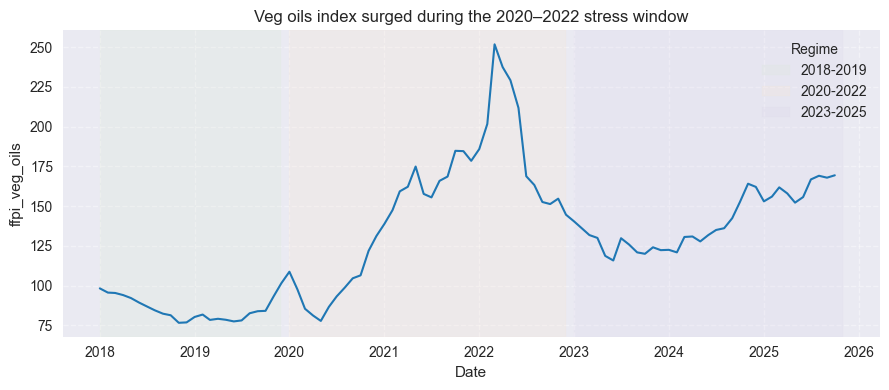

In [6]:

fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(df['date'], df['ffpi_veg_oils'], color='#1f77b4', linewidth=1.5)
ax.set_title('Veg oils index surged during the 2020–2022 stress window')
ax.set_ylabel('ffpi_veg_oils')
ax.set_xlabel('Date')

# Shade regimes for context
regime_colors = {'2018-2019': '#d9ead3', '2020-2022': '#fce5cd', '2023-2025': '#d9d2e9'}
for reg, group in df.groupby('regime'):
    ax.axvspan(group['date'].min(), group['date'].max(), color=regime_colors.get(reg, '#f0f0f0'), alpha=0.2, label=reg)

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), title='Regime')
ax.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()


Caveats and context:
- Sample sizes by regime: 2018-2019 n=24, 2020-2022 n=36, 2023-2025 n=34.
- Date coverage: 2018-2019: 2018-01-01 to 2019-12-01, 2020-2022: 2020-01-01 to 2022-12-01, 2023-2025: 2023-01-01 to 2025-11-01.
- Key differences: 2020-2022 vs 2018-2019: Δ = 65.19, ratio = 1.76; 2023-2025 vs 2018-2019: Δ = 55.16, ratio = 1.65.
- Data caveats: No missing values flagged for this KPI; monthly cadence is intact.

## CI3: Import price pressure (IPI food) stayed elevated through 2025  

- KPI: **ipi_food**  
- Relevance_score: **4**  
- Validation focus: Confirm the upward shift in the food import price index versus 2018–2019.

In [7]:

ci3_kpi = 'ipi_food'
ci3_summary = df.groupby('regime')[ci3_kpi].agg(mean='mean', median='median', N='count').reset_index()
ci3_summary['diff_vs_2018_2019'] = ci3_summary['mean'] - ci3_summary.loc[ci3_summary['regime'] == '2018-2019', 'mean'].iloc[0]
ci3_summary['ratio_vs_2018_2019'] = ci3_summary['mean'] / ci3_summary.loc[ci3_summary['regime'] == '2018-2019', 'mean'].iloc[0]
ci3_summary


C:\Users\betoq\AppData\Local\Temp\ipykernel_14856\3039196752.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ci3_summary = df.groupby('regime')[ci3_kpi].agg(mean='mean', median='median', N='count').reset_index()


,regime,mean,median,N,diff_vs_2018_2019,ratio_vs_2018_2019
0,2018-2019,87.758333,87.70,24,0.000000,1.000000
1,2020-2022,92.408333,91.25,36,4.650000,1.052986
2,2023-2025,100.018182,99.90,33,12.259848,1.139700


C:\Users\betoq\AppData\Local\Temp\ipykernel_14856\2473112631.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for reg, group in df.groupby('regime'):


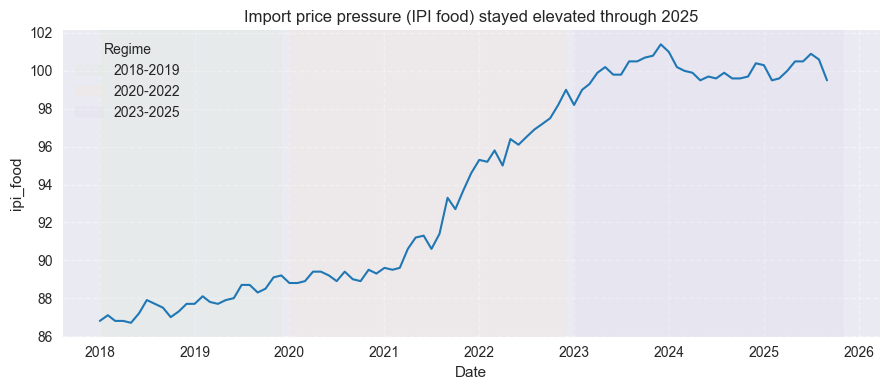

In [8]:

fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(df['date'], df['ipi_food'], color='#1f77b4', linewidth=1.5)
ax.set_title('Import price pressure (IPI food) stayed elevated through 2025')
ax.set_ylabel('ipi_food')
ax.set_xlabel('Date')

# Shade regimes for context
regime_colors = {'2018-2019': '#d9ead3', '2020-2022': '#fce5cd', '2023-2025': '#d9d2e9'}
for reg, group in df.groupby('regime'):
    ax.axvspan(group['date'].min(), group['date'].max(), color=regime_colors.get(reg, '#f0f0f0'), alpha=0.2, label=reg)

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), title='Regime')
ax.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()


Caveats and context:
- Sample sizes by regime: 2018-2019 n=24, 2020-2022 n=36, 2023-2025 n=33.
- Date coverage: 2018-2019: 2018-01-01 to 2019-12-01, 2020-2022: 2020-01-01 to 2022-12-01, 2023-2025: 2023-01-01 to 2025-11-01.
- Key differences: 2023-2025 vs 2018-2019: Δ = 12.26, ratio = 1.14; 2023-2025 vs 2020-2022: Δ = 7.61, ratio = 1.08.
- Data caveats: Missing IPI observations for 2025-10 and 2025-11 reduce the recent-sample N to 33.